In [1]:
# import required modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cooltools
import bioframe
import cooler

from cooltools import eigdecomp
import HMMC
from pybedtools import BedTool


In [53]:
assembly = 'hg19'

In [54]:
# todo: update this with storage location
# specify cooler and fasta storage locations
# cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
# cooler_file = '/pollard/data/wynton/consortia/4DN/krietenstein2020/H1-hESC/4DNFI9GMP2J8.mcool'
# cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/IMR90/4DNFIJTOIGOI.mcool'
cooler_file = '/pollard/data/chromatin_organization/rao2014/distiller-0.3.1_hg19/results/mcools/GM12878_inSitu_MboI.hg19.mapq_30.1000.mcool'
# fasta_file='/pollard/data/vertebrate_genomes/human/hg38/hg38/hg38.fa'
fasta_file='/pollard/data/vertebrate_genomes/human/'+assembly+'/' +assembly+'/' +assembly+'.fa'


In [55]:
cooler.fileops.list_coolers(cooler_file)

['/resolutions/1000',
 '/resolutions/2000',
 '/resolutions/5000',
 '/resolutions/10000',
 '/resolutions/25000',
 '/resolutions/50000',
 '/resolutions/100000',
 '/resolutions/250000',
 '/resolutions/500000',
 '/resolutions/1000000']

In [56]:
# load cooler, obtain bin table
resolution = 25000
c = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))
chromsizes = c.chromsizes      
bins = c.bins()[:]

In [57]:
# generate binned dataframe of GC content
fasta_records = bioframe.load_fasta(fasta_file)
gc_table = bioframe.genomeops.frac_gc(bins, fasta_records)

In [58]:
regions = HMMC.chrom_regions(assembly, chromsizes)
regions

[('chr1', 0, 249250621),
 ('chr2', 0, 243199373),
 ('chr3', 0, 198022430),
 ('chr4', 0, 191154276),
 ('chr5', 0, 180915260),
 ('chr6', 0, 171115067),
 ('chr7', 0, 159138663),
 ('chr8', 0, 146364022),
 ('chr9', 0, 141213431),
 ('chr10', 0, 135534747),
 ('chr11', 0, 135006516),
 ('chr12', 0, 133851895),
 ('chr13', 0, 115169878),
 ('chr14', 0, 107349540),
 ('chr15', 0, 102531392),
 ('chr16', 0, 90354753),
 ('chr17', 0, 81195210),
 ('chr18', 0, 78077248),
 ('chr19', 0, 59128983),
 ('chr20', 0, 63025520),
 ('chr21', 0, 48129895),
 ('chr22', 0, 51304566)]

In [59]:
# specify regions as autosomes, obtain cis eigenvectors
cis_val, cis_eig = eigdecomp.cooler_cis_eig(
                c, 
                gc_table,
                regions,
                n_eigs=3, 
                balance=True,
                ignore_diags = 2, clip_percentile=99)
cis_eig = cis_eig.iloc[ np.array([i.isdigit() for i in cis_eig.chrom.str.replace('chr','').values])]

In [60]:
def get_bics(build_model, get_bic, min_model, max_model, data):
    models = [build_model(data, n_components, constrain_transmat=False) for n_components in range(min_model, max_model + 1)]
    bics = [get_bic(model, data) for model in models]
    return bics, models

In [61]:
import importlib
importlib.reload(HMMC)
importlib.reload(HMMC.HMMC)


<module 'HMMC.HMMC' from '/pollard/home/lchumpitaz/Hi-C/testing/HMMC/HMMC.py'>

In [62]:
# min_model, max_model = 1, 10

# hmmlearn_bics = []
# chrom_models = []
# for chrom in cis_eig.chrom.unique():
#     mask = (~cis_eig['E1'].isna()) & (cis_eig.chrom == chrom)
#     print(chrom)
#     data = cis_eig[mask].E1.values.reshape(-1, 1)
#     print(len(data))
#     bics, models= get_bics(HMMC.HMMC._build_model, HMMC.HMMC._bic_hmm, min_model, max_model, data)
#     print(bics)
#     chrom_models.append(models)
#     hmmlearn_bics.append(bics)

In [63]:
# hmmlearn_bics = np.array(hmmlearn_bics)

In [64]:
# plt.plot(np.arange(min_model, max_model+1), hmmlearn_bics.T);
# plt.xticks(np.arange(min_model, max_model+1));
# plt.xlim([min_model - 0.1, max_model + 0.1])

In [65]:
# plt.plot(np.arange(min_model, max_model+1), hmmlearn_bics.mean(axis=0));
# plt.xticks(np.arange(min_model, max_model+1));
# plt.xlim([min_model - 0.1, max_model + 0.1])

In [66]:
# plt.plot(np.arange(min_model+1, max_model+1)-0.5, np.diff(hmmlearn_bics.mean(axis=0)));
# plt.xticks(np.arange(min_model, max_model+1));
# plt.xlim([min_model - 0.1, max_model + 0.1])

In [67]:
# get segmentation using HMMC
hmm_track, BIC_dict = HMMC.get_segmentation(cis_eig, 
                                  state_list= ["binary", "HMM2","HMM3", "HMM3P"], 
                                  regions=regions, return_BIC_dict=True, verbose=True)

generating segmentation for binary
generating segmentation for HMM2
generating segmentation for HMM3
generating segmentation for HMM3P


In [68]:
bics = [(key, vals) for key, vals in BIC_dict.items()]
bics.sort(key=lambda x: x[0])
bics_vals = np.array([vals for key, vals in bics])

In [69]:
bics_vals

array([ 36183.81581719, -29123.21527624])

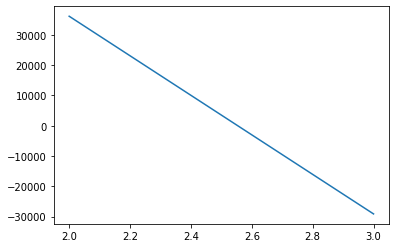

In [70]:
plt.plot(np.arange(2, len(bics_vals)+2), bics_vals)

In [71]:
# x = np.arange(2.5, 9.5, 1)
# plt.plot(x, np.diff(bics_vals))
# plt.xlim([1.5, 10])

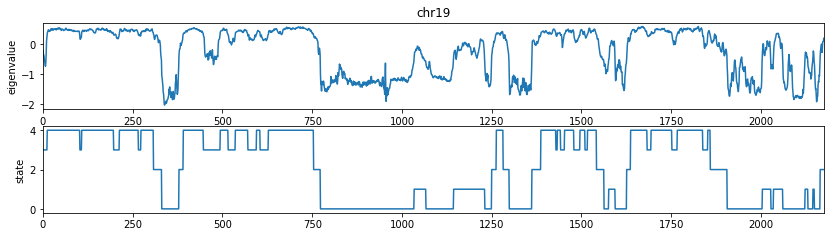

In [72]:
# visualize eigenvector and HMM3P segmentation for chromosome 19
# HMM3P_nums_to_names =  {0:'B', 1:'M_{bb}', 2:'M', 3:'M_{aa}', 4:'A'}
# HMM2_nums_to_names  =  {0:'B', 1:'A'}

fig = plt.figure(figsize=(14, 3.5))

ax1 = plt.subplot(211)
chrom = 'chr19'
mask = (~hmm_track['E1'].isna()) & (hmm_track.chrom == chrom)
y1 = hmm_track[mask]['E1'].values
ax1.plot(y1)
ax1.margins(x=0)
ax1.set_ylabel('eigenvalue')
plt.title(chrom)

# plt.figure(figsize=(14, 1.5))
ax2 = plt.subplot(212)
y2 = hmm_track[mask]['HMM3P'].values 
ax2.plot(y2)
ax2.set_ylabel('state')
ax2.margins(x=0)

In [73]:
hmm_track

,chrom,start,end,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P
0,chr1,0,25000,NaN,0.573067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,25000,50000,NaN,0.430960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,50000,75000,NaN,0.351400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,75000,100000,NaN,0.402080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,100000,125000,NaN,0.371200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
115249,chr22,51200000,51225000,NaN,0.484840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115250,chr22,51225000,51250000,NaN,0.399060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115251,chr22,51250000,51275000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115252,chr22,51275000,51300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
bed_track = HMMC.track_to_bedformat(hmm_track, 'HMM3P')
bed_track

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
0,chr1,0,25000,N,0,-,0,25000,"248,248,248"
1,chr1,25000,50000,N,0,-,25000,50000,"248,248,248"
2,chr1,50000,75000,N,0,-,50000,75000,"248,248,248"
3,chr1,75000,100000,N,0,-,75000,100000,"248,248,248"
4,chr1,100000,125000,N,0,-,100000,125000,"248,248,248"
...,...,...,...,...,...,...,...,...,...
115249,chr22,51200000,51225000,N,0,-,51200000,51225000,"248,248,248"
115250,chr22,51225000,51250000,N,0,-,51225000,51250000,"248,248,248"
115251,chr22,51250000,51275000,N,0,-,51250000,51275000,"248,248,248"
115252,chr22,51275000,51300000,N,0,-,51275000,51300000,"248,248,248"


In [75]:
hmm_track.to_csv('../annotations/GM12878_'+assembly+'_'+str(resolution)+'.tsv', sep='\t', index=False)
BedTool.from_dataframe(bed_track, outfile='../annotations/GM12878_'+assembly+'_'+str(resolution)+'.bed', header = False )
# hmm_track.to_csv('../annotations/H1-hESC_hg38_50kb.tsv', sep='\t', index=False)
# hmm_track.to_csv('../annotations/IMR90_hg38_25kb.tsv', sep='\t', index=False)
# BedTool.from_dataframe(bed_track, outfile='../annotations/IMR90_hg38_25kb.bed', header = False )

<BedTool(../annotations/GM12878_hg19_25000.bed)>